In [1]:
from pathlib import Path

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from walmart_sales.constants import PROCESSED_DATA_DIR, PROCESSED_DATA_FILE
from walmart_sales.data import WalmartDataset, WalmartDataTransformer
from walmart_sales.evaluation import validate, mape, smape, wape
from walmart_sales.model import WalmartLGBM
from walmart_sales.visualization import plot_forecast_vs_target

In [2]:
df = pd.read_csv(Path("..", PROCESSED_DATA_DIR, PROCESSED_DATA_FILE), parse_dates=["Date"])

In [3]:
dataset = WalmartDataset(df)
transformer = WalmartDataTransformer()
lgbm_regressor = LGBMRegressor()
model = WalmartLGBM(lgbm_regressor, transformer)

# Data

In [4]:
len(dataset.full)

1384594

In [5]:
list(dataset.full.columns)

['Store',
 'Dept',
 'lag_12',
 'lag_11',
 'lag_10',
 'lag_9',
 'lag_8',
 'lag_7',
 'lag_6',
 'lag_5',
 'lag_4',
 'lag_3',
 'lag_2',
 'lag_1',
 'horizon',
 'target',
 'forecast_week',
 'targeted_week',
 'IsHoliday',
 'Type',
 'Size',
 'Temperature_lag_12',
 'Temperature_lag_11',
 'Temperature_lag_10',
 'Temperature_lag_9',
 'Temperature_lag_8',
 'Temperature_lag_7',
 'Temperature_lag_6',
 'Temperature_lag_5',
 'Temperature_lag_4',
 'Temperature_lag_3',
 'Temperature_lag_2',
 'Temperature_lag_1',
 'Fuel_Price_lag_12',
 'Fuel_Price_lag_11',
 'Fuel_Price_lag_10',
 'Fuel_Price_lag_9',
 'Fuel_Price_lag_8',
 'Fuel_Price_lag_7',
 'Fuel_Price_lag_6',
 'Fuel_Price_lag_5',
 'Fuel_Price_lag_4',
 'Fuel_Price_lag_3',
 'Fuel_Price_lag_2',
 'Fuel_Price_lag_1',
 'CPI_lag_12',
 'CPI_lag_11',
 'CPI_lag_10',
 'CPI_lag_9',
 'CPI_lag_8',
 'CPI_lag_7',
 'CPI_lag_6',
 'CPI_lag_5',
 'CPI_lag_4',
 'CPI_lag_3',
 'CPI_lag_2',
 'CPI_lag_1',
 'Unemployment_lag_12',
 'Unemployment_lag_11',
 'Unemployment_lag_10',
 '

In [6]:
dataset.full.head()

,Store,Dept,lag_12,lag_11,lag_10,lag_9,lag_8,lag_7,lag_6,lag_5,...,MarkDown5_lag_10,MarkDown5_lag_9,MarkDown5_lag_8,MarkDown5_lag_7,MarkDown5_lag_6,MarkDown5_lag_5,MarkDown5_lag_4,MarkDown5_lag_3,MarkDown5_lag_2,MarkDown5_lag_1
0,1,1,24924.50,46039.49,41595.55,19403.54,21827.90,21043.39,22136.64,26229.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,24924.50,46039.49,41595.55,19403.54,21827.90,21043.39,22136.64,26229.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,24924.50,46039.49,41595.55,19403.54,21827.90,21043.39,22136.64,26229.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1,24924.50,46039.49,41595.55,19403.54,21827.90,21043.39,22136.64,26229.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2,50605.27,44682.74,47928.89,44292.87,48397.98,43751.94,43615.49,41892.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
dataset.full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384594 entries, 0 to 1384593
Columns: 129 entries, Store to MarkDown5_lag_1
dtypes: bool(1), datetime64[ns](2), float64(122), int64(3), object(1)
memory usage: 1.3+ GB


In [8]:
X = WalmartDataTransformer().fit_transform(dataset.full)[0]
X.columns

Index(['lag_12', 'lag_11', 'lag_10', 'lag_9', 'lag_8', 'lag_7', 'lag_6',
       'lag_5', 'lag_4', 'lag_3', 'lag_2', 'lag_1', 'horizon', 'store_size',
       'store_type_A', 'store_type_B', 'is_holiday', 'targeted_week_number',
       'forecast_week_number', 'delta_11', 'delta_10', 'delta_9', 'delta_8',
       'delta_7', 'delta_6', 'delta_5', 'delta_4', 'delta_3', 'delta_2',
       'delta_1', 'temperature_delta', 'fuel_price_delta', 'cpi_delta',
       'unemployment_delta', 'markdown1_lag_1', 'markdown2_lag_1',
       'markdown3_lag_1', 'markdown4_lag_1', 'markdown5_lag_1'],
      dtype='object')

In [9]:
X.head()

,lag_12,lag_11,lag_10,lag_9,lag_8,lag_7,lag_6,lag_5,lag_4,lag_3,...,delta_1,temperature_delta,fuel_price_delta,cpi_delta,unemployment_delta,markdown1_lag_1,markdown2_lag_1,markdown3_lag_1,markdown4_lag_1,markdown5_lag_1
0,24924.50,46039.49,41595.55,19403.54,21827.90,21043.39,22136.64,26229.21,57258.43,42960.91,...,-1451.61,1.48,0.013,0.049577,0.0,0.0,0.0,0.0,0.0,0.0
1,24924.50,46039.49,41595.55,19403.54,21827.90,21043.39,22136.64,26229.21,57258.43,42960.91,...,-1451.61,1.48,0.013,0.049577,0.0,0.0,0.0,0.0,0.0,0.0
2,24924.50,46039.49,41595.55,19403.54,21827.90,21043.39,22136.64,26229.21,57258.43,42960.91,...,-1451.61,1.48,0.013,0.049577,0.0,0.0,0.0,0.0,0.0,0.0
3,24924.50,46039.49,41595.55,19403.54,21827.90,21043.39,22136.64,26229.21,57258.43,42960.91,...,-1451.61,1.48,0.013,0.049577,0.0,0.0,0.0,0.0,0.0,0.0
4,50605.27,44682.74,47928.89,44292.87,48397.98,43751.94,43615.49,41892.55,47450.50,46549.73,...,-606.91,1.48,0.013,0.049577,0.0,0.0,0.0,0.0,0.0,0.0


# Validation and hyperparameter search

In [10]:
def score(params):
    params["n_estimators"] = int(params["n_estimators"])
    params["max_depth"] = int(params["max_depth"])
    params["min_child_samples"] = int(params["min_child_samples"])
    lgbm_regressor = LGBMRegressor(**params)
    transformer = WalmartDataTransformer()
    error, _ = validate(
        dataset.val_ts_split, WalmartLGBM(lgbm_regressor, transformer), smape
    )
    print("SMAPE {0}".format(error))
    return {"loss": error, "status": STATUS_OK}

In [11]:
space = {
    "n_estimators": hp.quniform("n_estimators", 50, 300, 1),
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.1)),
    "max_depth": hp.quniform("max_depth", 2, 4, 1),
    "min_child_samples": hp.quniform("min_child_samples", 0, 100, 1),
    "reg_alpha": hp.uniform("reg_alpha", 0, 10),
    "reg_lambda": hp.uniform("reg_lambda", 0, 10),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
}
best_params = fmin(
    score, space, algo=tpe.suggest, max_evals=20, rstate=np.random.default_rng(42)
)

SMAPE 17.239851033280083                                                                                                
SMAPE 17.420484831543966                                                                                                
SMAPE 18.88265535461739                                                                                                 
SMAPE 16.746869718402728                                                                                                
SMAPE 17.431362992339352                                                                                                
SMAPE 16.72221175683993                                                                                                 
SMAPE 16.240499379624644                                                                                                
SMAPE 19.184455051792092                                                                                                
SMAPE 18.29786598368328         

In [12]:
best_params["n_estimators"] = int(best_params["n_estimators"])
best_params["max_depth"] = int(best_params["max_depth"])
best_params["min_child_samples"] = int(best_params["min_child_samples"])
best_params

{'colsample_bytree': 0.5045399812671432,
 'learning_rate': 0.023137426169141273,
 'max_depth': 3,
 'min_child_samples': 45,
 'n_estimators': 254,
 'reg_alpha': 8.140834674473611,
 'reg_lambda': 8.82267604974632}

## Test

In [13]:
lgbm_regressor = LGBMRegressor(**best_params)
transformer = WalmartDataTransformer()
model = WalmartLGBM(lgbm_regressor, transformer)

In [14]:
test_smape, df_test_with_preds = validate(dataset.test_ts_split, model, smape, verbose=True)

Validating fold 1...
Validating fold 2...
Validating fold 3...
Validating fold 4...
Validating fold 5...
Validating fold 6...
Validating fold 7...
Validating fold 8...
Validating fold 9...
Validating fold 10...
Validating fold 11...
Validating fold 12...


In [15]:
test_smape

19.01862109825387

In [16]:
smape_by_horizon = df_test_with_preds.groupby("horizon").apply(
    lambda x: pd.Series(
        [smape(x.target, x.pred), len(x.target), len(x[["Store", "Dept"]].drop_duplicates())], 
        index=["smape", "data points", "departments"]
    )
).sort_index()
smape_by_horizon

,smape,data points,departments
horizon,,,
1,16.196186,32113.0,2681.0
2,18.796056,29438.0,2681.0
3,20.443289,26762.0,2680.0
4,21.470741,24086.0,2679.0


<Axes: xlabel='horizon', ylabel='SMAPE'>

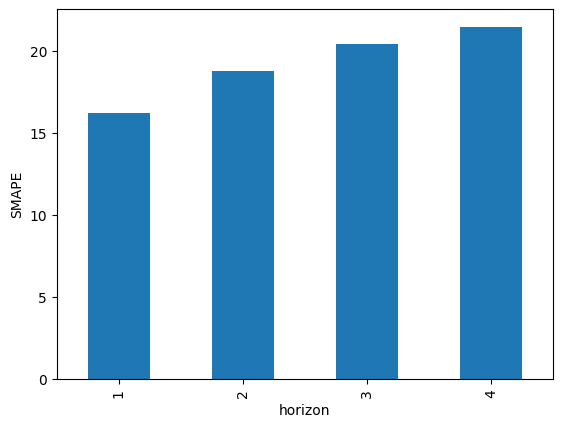

In [17]:
plt.ylabel("SMAPE")
smape_by_horizon["smape"].plot.bar()

In [18]:
smape_by_department = df_test_with_preds.groupby("Dept").apply(
    lambda x: pd.Series(
        [smape(x.target, x.pred), len(x.target), len(x[["Store", "Dept"]].drop_duplicates())], 
        index=["smape", "data points", "departments"]
    )
).sort_values("smape")
smape_by_department

,smape,data points,departments
Dept,,,
8,4.478668,1890.0,45.0
40,4.787891,1890.0,45.0
90,5.444486,1890.0,45.0
94,5.632668,1176.0,28.0
13,6.073131,1890.0,45.0
...,...,...,...
59,51.743398,1428.0,34.0
36,59.429428,1512.0,36.0
54,122.837689,42.0,1.0


<Axes: xlabel='Dept', ylabel='SMAPE'>

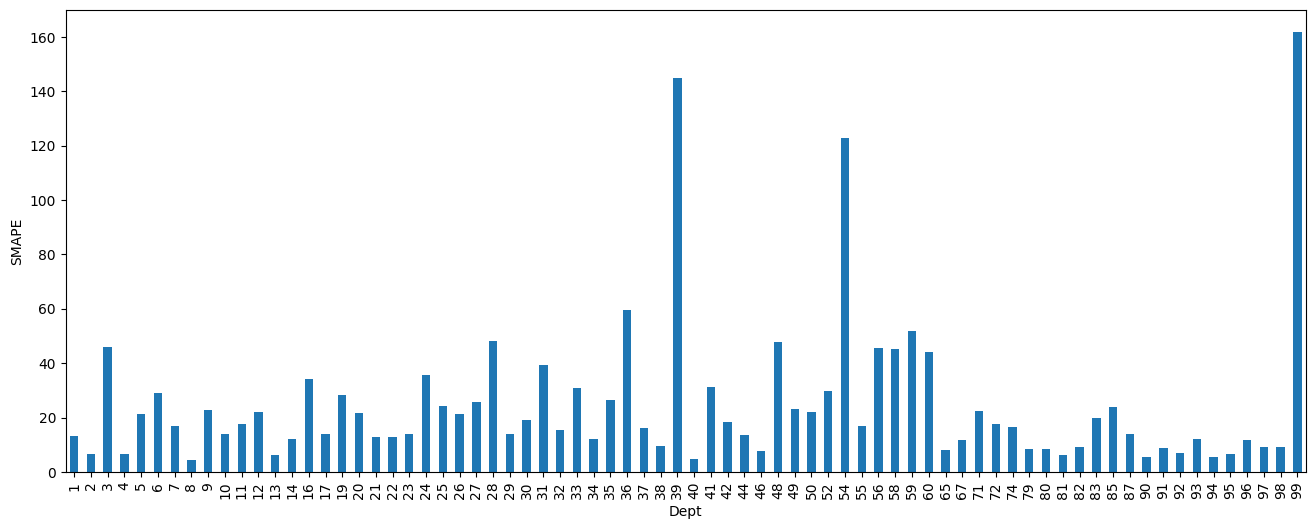

In [19]:
plt.figure(figsize=(16,6))
plt.ylabel("SMAPE")
smape_by_department["smape"].sort_index().plot.bar()

In [20]:
smape_by_forecast_week = df_test_with_preds.groupby("forecast_week").apply(
    lambda x: pd.Series(
        [smape(x.target, x.pred), len(x.target), len(x[["Store", "Dept"]].drop_duplicates())], 
        index=["smape", "data points", "departments"]
    )
).sort_index()
smape_by_forecast_week

,smape,data points,departments
forecast_week,,,
2012-08-03,16.130067,10703.0,2678.0
2012-08-10,19.774277,10704.0,2678.0
2012-08-17,21.065494,10706.0,2679.0
2012-08-24,23.142537,10706.0,2678.0
2012-08-31,25.091091,10706.0,2678.0
2012-09-07,21.844352,10707.0,2679.0
2012-09-14,18.617092,10705.0,2677.0
2012-09-21,15.379020,10705.0,2677.0
2012-09-28,15.579442,10704.0,2677.0


<Axes: xlabel='forecast_week'>

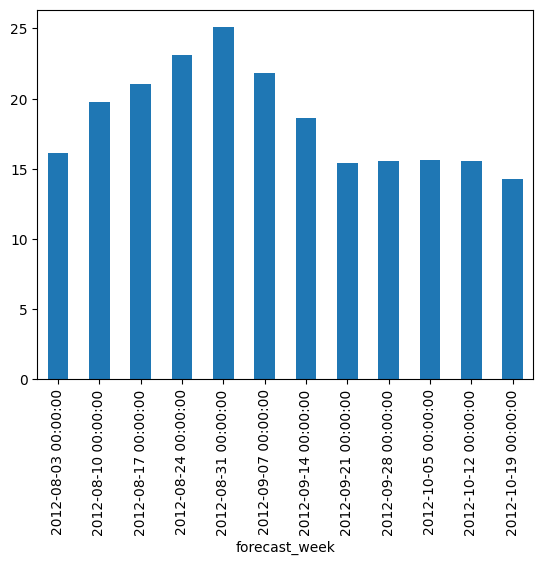

In [21]:
smape_by_forecast_week["smape"].plot.bar()

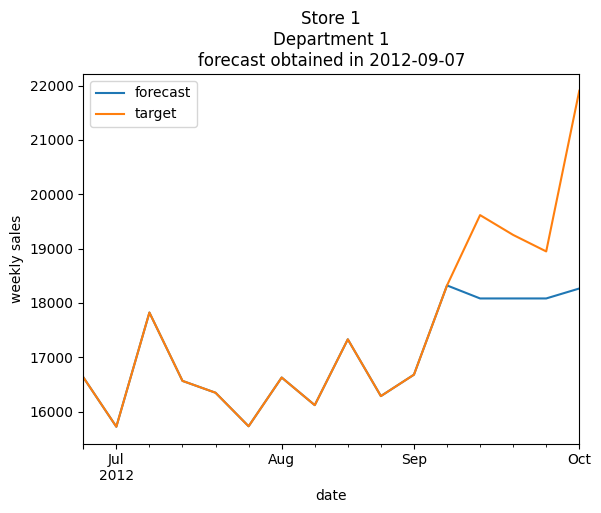

In [22]:
plot_forecast_vs_target(df_test_with_preds, 1, 1, "2012-09-07")

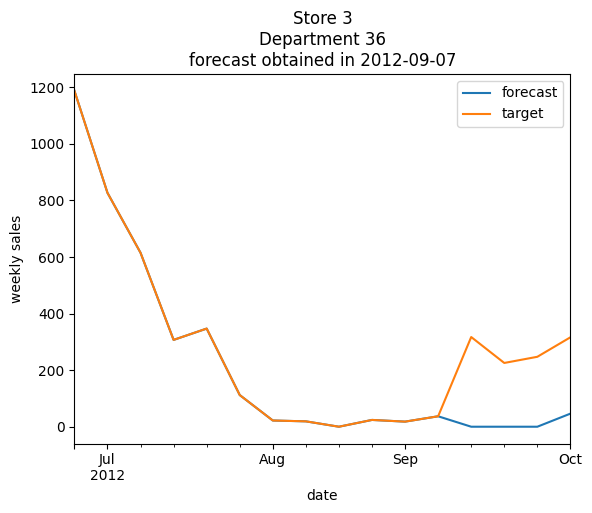

In [23]:
plot_forecast_vs_target(df_test_with_preds, 3, 36, "2012-09-07")

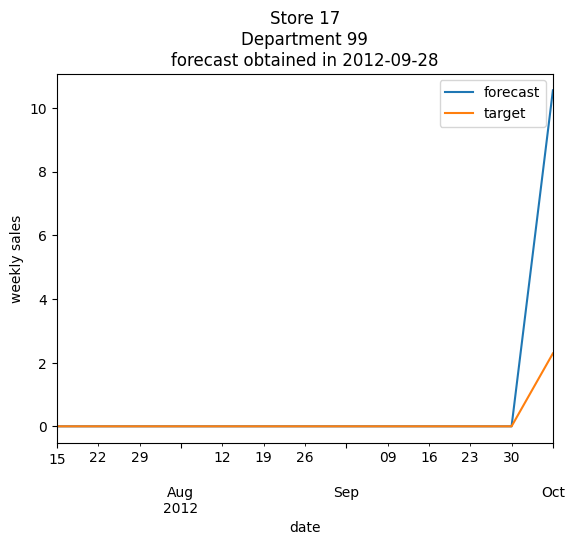

In [24]:
plot_forecast_vs_target(df_test_with_preds, 17, 99, "2012-09-28")